# Goals for Script
- answer the question: Can upper leg, middle leg(with sunscreen), and lower leg be decoded from eachother?

Model and dataloading heavily based on:
https://www.learnpytorch.io/04_pytorch_custom_datasets/#52-create-a-custom-dataset-to-replicate-imagefolder


In [1]:
import torch
import numpy as np
import random

# Set random seed for PyTorch
torch.manual_seed(0)

# Set random seed for NumPy
np.random.seed(0)

# Set random seed for Python
random.seed(0)


In [2]:
import os 
import pathlib
from pathlib import Path

type1path = '/Users/maycaj/Documents/Hyperspectral-Imaging_II/Lipstick Input/Train/Lipstick 1/'
type2path = '/Users/maycaj/Documents/Hyperspectral-Imaging_II/Lipstick Input/Train/Lipstick 2/'
type3path = '/Users/maycaj/Documents/Hyperspectral-Imaging_II/Lipstick Input/Train/Lipstick 3/'

def FindFilepaths(directory):
    filepaths = []
    for dirpath, dirnames, filenames in os.walk(directory):
        for filename in filenames:
            if filename[-4:] == '.npy':
                filepaths.append(directory + filename)
    return filepaths

type1paths = FindFilepaths(type1path)
type2paths = FindFilepaths(type2path)
type3paths = FindFilepaths(type3path)

print(type1paths)

['/Users/maycaj/Documents/Hyperspectral-Imaging_II/Lipstick Input/Train/Lipstick 1/Lipstick type 1 image 10.npy', '/Users/maycaj/Documents/Hyperspectral-Imaging_II/Lipstick Input/Train/Lipstick 1/Lipstick type 1 image 11.npy', '/Users/maycaj/Documents/Hyperspectral-Imaging_II/Lipstick Input/Train/Lipstick 1/Lipstick type 1 image 12.npy', '/Users/maycaj/Documents/Hyperspectral-Imaging_II/Lipstick Input/Train/Lipstick 1/Lipstick type 1 image 8.npy', '/Users/maycaj/Documents/Hyperspectral-Imaging_II/Lipstick Input/Train/Lipstick 1/Lipstick type 1 image 9.npy', '/Users/maycaj/Documents/Hyperspectral-Imaging_II/Lipstick Input/Train/Lipstick 1/Lipstick type 1 image 4.npy', '/Users/maycaj/Documents/Hyperspectral-Imaging_II/Lipstick Input/Train/Lipstick 1/Lipstick type 1 image 5.npy', '/Users/maycaj/Documents/Hyperspectral-Imaging_II/Lipstick Input/Train/Lipstick 1/Lipstick type 1 image 7.npy', '/Users/maycaj/Documents/Hyperspectral-Imaging_II/Lipstick Input/Train/Lipstick 1/Lipstick type 1 im

# Step 0: Image loading test

Tried but didn't work:
- torchvision.datasets.ImageFolder
- torchvision.datasets.DatasetFolder

In [3]:
import numpy as np
test_filepath = '/Users/maycaj/Documents/Hyperspectral-Imaging_II/Lipstick Input/Train/Lipstick 1/Lipstick type 1 image 1.npy'
test = np.load(test_filepath)
print(test.dtype)
print(f'Loaded datatype: {test.dtype}')
if test.dtype == 'float32':
    print('pixel_loaded has correct datatype')
else:
    raise Exception('INCORRECT DATATYPE')
def read_npy(filepath):
    file = np.load(filepath)
    return file

float32
Loaded datatype: float32
pixel_loaded has correct datatype


In [4]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class CubeDataset(Dataset):
    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # We only load the images using readcube when it is needed so this is lazy loading. If I have issues with memory I can implement a cache for subsequent access https://discuss.pytorch.org/t/best-practice-to-cache-the-entire-dataset-during-first-epoch/19608
        cube_path = self.file_paths[idx]
        # Custom code to read .cube format image
        cube_image = read_npy(cube_path)
        cube_image = np.array(cube_image)
        # Convert cube image to numpy array and then to PyTorch tensor
        cube_tensor = torch.from_numpy(cube_image).float()
        return cube_tensor

# Example usage
custom_dataset = CubeDataset(type1paths)

# Create DataLoader for batching and shuffling
data_loader = torch.utils.data.DataLoader(custom_dataset, batch_size=4, shuffle=True)


## Visualize to see if the Dataloader worked



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


len(train_features_batch): 4
torch.Size([4, 520, 696, 128])
Random_idx: 2
masked shape: torch.Size([520, 696, 128])
masked_red shape: torch.Size([520, 696])
np_pixel_color shape (520, 696, 3)


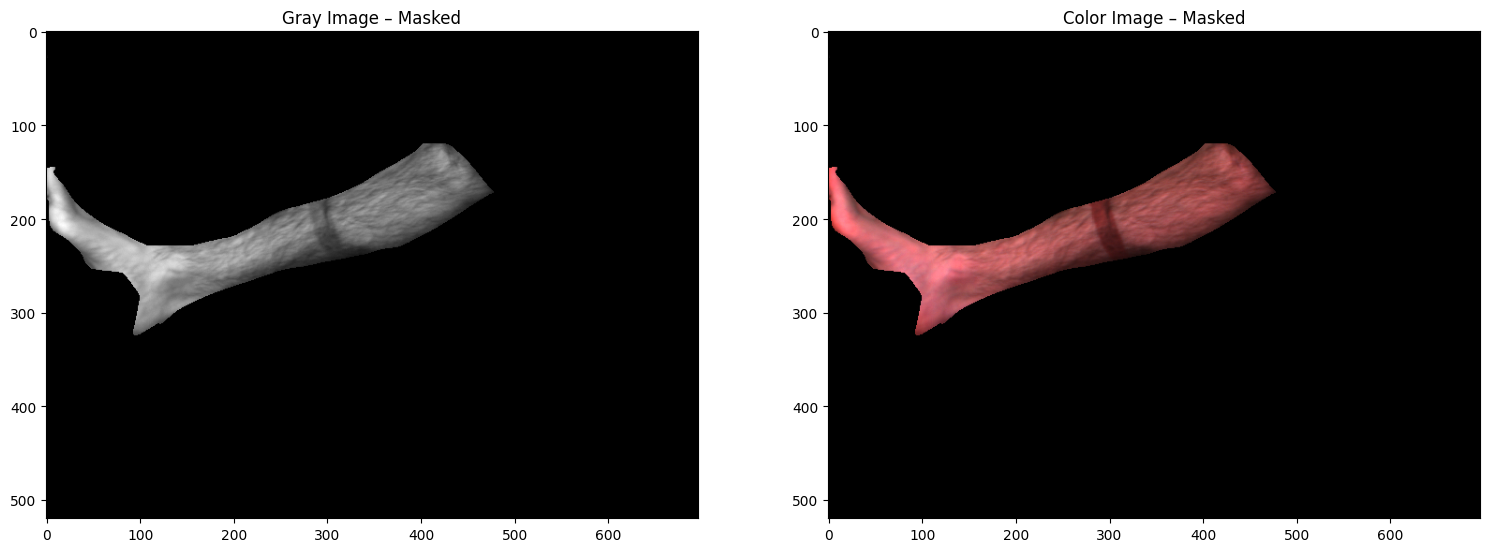

In [5]:
import matplotlib.pyplot as plt

# Check out what's inside the training dataloader
train_features_batch = next(iter(data_loader)) # calls the next iteration of data_loader – which is the images in each batch
print(f"len(train_features_batch): {len(train_features_batch)}")
print(train_features_batch.shape)
torch.manual_seed(6)
# Find a random index to display
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img = train_features_batch[random_idx]
print(f"Random_idx: {random_idx}")

def plot(img):
    # Create a new figure with two subplots
    fig, (ax3, ax4) = plt.subplots(1, 2)
    fig.set_size_inches(18.5, 10.5) #plot it big!


    # Only display the 49th band in gray
    masked_grey = img[:, :, 49:50]
    print('masked shape:', img.shape)

    # Display the gray image in the first subplot
    ax3.imshow(masked_grey, cmap='gray')
    ax3.set_title('Gray Image – Masked')

    # Grab the colored bands
    masked_red = img[:,:,20]
    masked_green = img[:,:,35]
    masked_blue = img[:,:,60]

    # # Normalize the bands to [0, 1] for each color channel
    # masked_red = (masked_red - np.min(masked_red)) / (np.max(masked_red) - np.min(masked_red))
    # masked_green = (masked_green - np.min(masked_green)) / (np.max(masked_green) - np.min(masked_green))
    # masked_blue = (masked_blue - np.min(masked_blue)) / (np.max(masked_blue) - np.min(masked_blue))

    print('masked_red shape:', masked_red.shape)

    masked_color = np.dstack((masked_blue,masked_green,masked_red))
    print('np_pixel_color shape',masked_color.shape)

    # Display the color image in the second subplot
    ax4.imshow(masked_color)
    ax4.set_title('Color Image – Masked')

    # Show the figure with both subplots
    plt.show()

plot(img)

# Test out transforms V2
https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_getting_started.html#sphx-glr-auto-examples-transforms-plot-transforms-getting-started-py

Bigger article: 
https://pytorch.org/vision/stable/transforms.html

/Users/maycaj/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


img.shape: torch.Size([520, 696, 128])
img_transposed.shape: torch.Size([128, 696, 520])
out_transposed.shape torch.Size([128, 224, 224])
out.shape torch.Size([224, 224, 128])
masked shape: torch.Size([224, 224, 128])
masked_red shape: torch.Size([224, 224])
np_pixel_color shape (224, 224, 3)


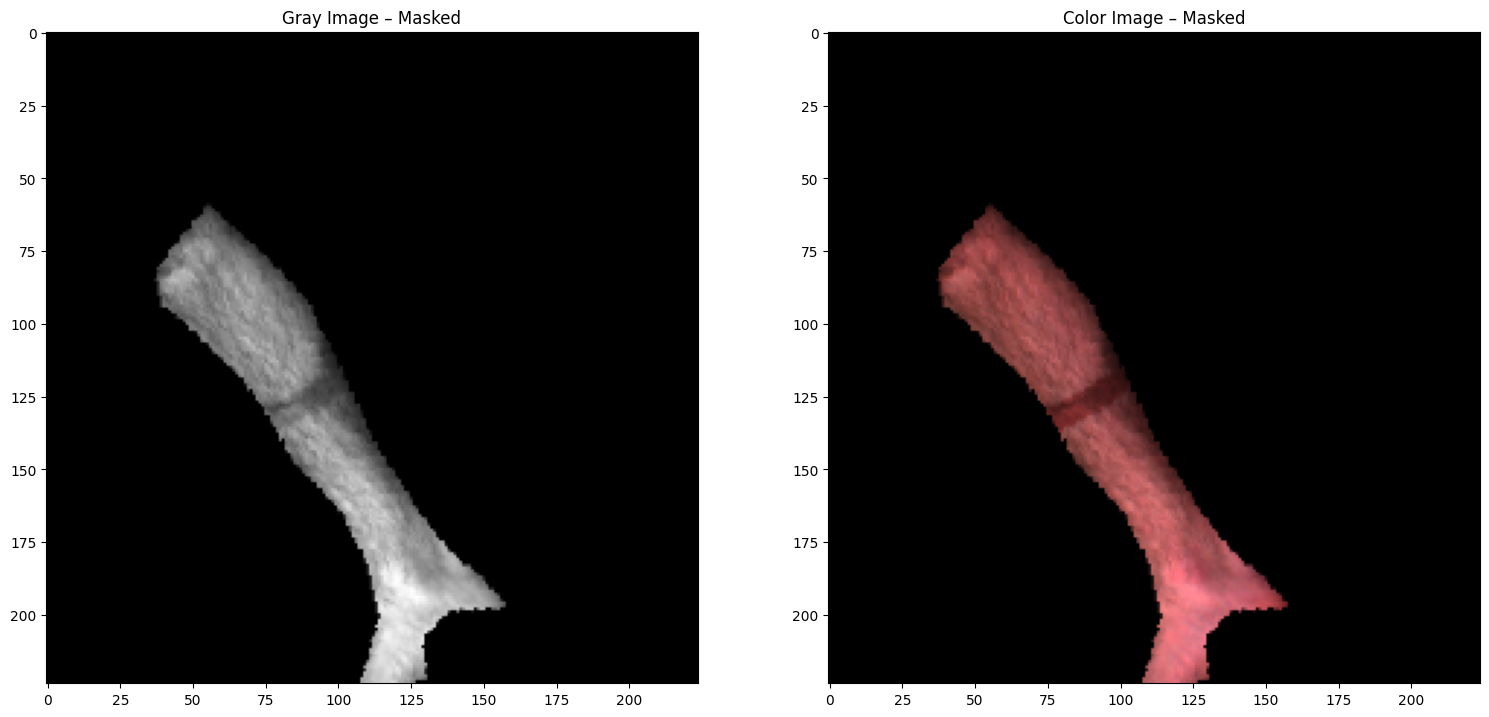

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


masked shape: torch.Size([520, 696, 128])
masked_red shape: torch.Size([520, 696])
np_pixel_color shape (520, 696, 3)


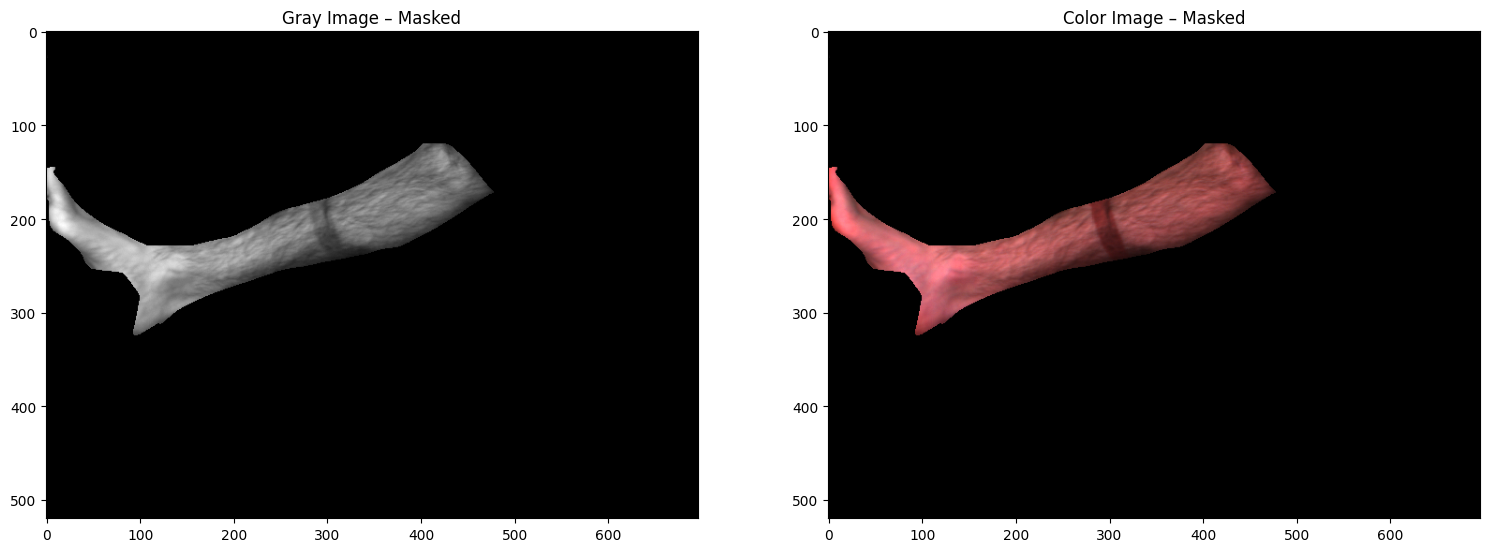

In [6]:
from torchvision.transforms import v2
# transform = v2.RandomCrop(size=(500, 500))
transform = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), scale = (0.5,2), antialias=False), # crops to 224 by 224 within scale of 0.5 to 2
    v2.RandomHorizontalFlip(p=0.5), # flips horizontally half of the time
    v2.RandomRotation(degrees=(-180,180)), # rotates from -180 to 180 randomly
    v2.ToDtype(torch.float32, scale=True),
])

print(f"img.shape: {img.shape}")
# we need to transpose the dimensions to be (bands, height, width) before using PyTorch
img_transposed = np.transpose(img, (2, 1, 0))
print(f"img_transposed.shape: {img_transposed.shape}")
out_transposed = transform(img_transposed)
print(f"out_transposed.shape {out_transposed.shape}")
out = np.transpose(out_transposed, (2, 1, 0))
print(f"out.shape {out.shape}")
plot(out)
plot(img)


The following titles for the rest of the script are based on this reference:
https://www.learnpytorch.io/04_pytorch_custom_datasets/#5-option-2-loading-image-data-with-a-custom-dataset

# **Option 2:** Loading Image Data with a Custom Dataset
# **5.1**: Create a helper function to get class names


In [7]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List


In [8]:
from pathlib import Path
image_path = Path('/Users/maycaj/Documents/Hyperspectral-Imaging_II/Lipstick Input')


### Test to see if we can get classes from folder names

In [9]:
# Setup path for target directory
target_directory = '/Users/maycaj/Documents/Hyperspectral-Imaging_II/Lipstick Input/Train'
print(f"Target directory: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"Class names found: {class_names_found}")

Target directory: /Users/maycaj/Documents/Hyperspectral-Imaging_II/Lipstick Input/Train
Class names found: ['.DS_Store', 'Lipstick 1', 'Lipstick 2', 'Lipstick 3']


In [10]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.
    
    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    
    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [11]:
train_dir = image_path / "train"
print(train_dir)
find_classes(train_dir)

/Users/maycaj/Documents/Hyperspectral-Imaging_II/Lipstick Input/train


(['Lipstick 1', 'Lipstick 2', 'Lipstick 3'],
 {'Lipstick 1': 0, 'Lipstick 2': 1, 'Lipstick 3': 2})

# **5.2** Create a custom `Dataset` to replicate `ImageFolder`

I have placed comments where I have modified the script

In [12]:
# Write a custom dataset class (inherits from torch.utils.data.Dataset)
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    
    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:
        
        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.npy")) # modified from '*/*.jpg'
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        image = np.load(image_path) # modified from opening a PNG file
        # print(image.shape)
        #change from [696, 520, 128] [width, height, channels] to [channels, height, width]
        image = np.transpose(image, (2, 1, 0))
        image = torch.from_numpy(image)
        return image 
    
    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]
                # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)

In [13]:
# Setup train and testing paths
train_dir = image_path / "Train"
test_dir = image_path / "Valid"
train_dir, test_dir

(PosixPath('/Users/maycaj/Documents/Hyperspectral-Imaging_II/Lipstick Input/Train'),
 PosixPath('/Users/maycaj/Documents/Hyperspectral-Imaging_II/Lipstick Input/Valid'))

In [14]:
# Augment train data
# train_transforms = transforms.Compose([
#     transforms.Resize((64, 64)),
#     transforms.RandomHorizontalFlip(p=0.5),
#     # don't need to cast back to tensor because they are already tensors
# ])

# # Don't augment test data, only reshape
# test_transforms = transforms.Compose([
#     transforms.Resize((64, 64)),
# ])

train_transforms = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), scale = (3,4), antialias=False), # crops to 224 by 224 within scale of 0.5 to 2 - also crops to a random location
    v2.RandomHorizontalFlip(p=0.5), # flips horizontally half of the time
    v2.RandomRotation(degrees=(-180,180)), # rotates from -180 to 180 randomly
    v2.ToDtype(torch.float32, scale=True),
])

test_transforms = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), scale = (3,4), antialias=False), # crops to 224 by 224 within scale of 0.5 to 2 - also crops to a random location
    v2.RandomHorizontalFlip(p=0.5), # flips horizontally half of the time
    v2.RandomRotation(degrees=(-180,180)), # rotates from -180 to 180 randomly
    v2.ToDtype(torch.float32, scale=True),
])

In [15]:
# Let's turn our training and testing data into Datasets by using our own ImageFolderCustom class

train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms
                                      )
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms
                                     )
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x114c75c10>,
 <__main__.ImageFolderCustom at 0x144c473a0>)

img is converted to a ndarray in this cell: 

In [16]:
print(f'length of train_data_custom: {len(train_data_custom)}')
print(f'length of test_data_custom: {len(test_data_custom)}')
classes = train_data_custom.classes
print(f'Classes: {classes}')
print(f'Integer labels of classes: {train_data_custom.class_to_idx}')
dataset_size = len(train_data_custom)
num_classes = len(classes)
img_dict = {}
for i in range(num_classes):
    img_dict[classes[i]] = 0

for i in range(dataset_size):
    img, label = train_data_custom[i]
    img_dict[classes[label]] += 1
print(f'Number of photos in each class: {img_dict}')

length of train_data_custom: 35
length of test_data_custom: 9
Classes: ['Lipstick 1', 'Lipstick 2', 'Lipstick 3']
Integer labels of classes: {'Lipstick 1': 0, 'Lipstick 2': 1, 'Lipstick 3': 2}
Number of photos in each class: {'Lipstick 1': 12, 'Lipstick 2': 12, 'Lipstick 3': 11}


# **5.3:** Create a function to display random images


Everything I have modified has a # modified ... comment next to it

In [17]:
import random 

# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset, 
                       # (argument name: type hint,..
                          classes: List[str] = None,
                       # argument: type hint = default value   
                          n: int = 5,
                          display_shape: bool = True,
                          seed: int = None):
    
    print(f'dataset: {dataset}') # modified

    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n) #finds n random images

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        #change from [channels, height, width] to [696, 520, 128] [width, height, channels]
        targ_image = np.transpose(targ_image, (2, 1, 0))

        # Grab the colored bands
        red = targ_image[:,:,20]
        green = targ_image[:,:,35]
        blue = targ_image[:,:,60]

        # Normalize the bands to [0, 1] for each color channel
        # red = (red - np.min(red)) / (np.max(red) - np.min(red))
        # green = (green - np.min(green)) / (np.max(green) - np.min(green))
        # blue = (blue - np.min(blue)) / (np.max(blue) - np.min(blue))

        #Combine bands into color image
        color_img = np.dstack((blue,green,red))

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(color_img)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image.shape}"
            title = title + f"\nIndex: {targ_sample}"
        plt.title(title, fontsize = 10)

There will be an error saying "Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers)." Our data is from 0 to 1 and some of the values will be very slightly over 1. For example: 1.0356554 1.0142472. This should not be a problem for how the model is trained, rather it only throws a non-fatal error during data display.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dataset: <__main__.ImageFolderCustom object at 0x114c75c10>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


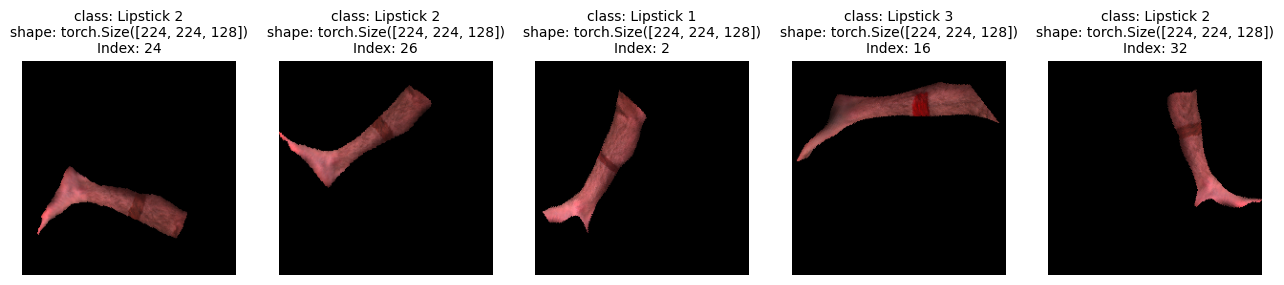

In [18]:
display_random_images(train_data_custom, #modified
                      n=5, 
                      classes=train_data_custom.classes,
                      seed=None)

dataset: <__main__.ImageFolderCustom object at 0x144c473a0>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


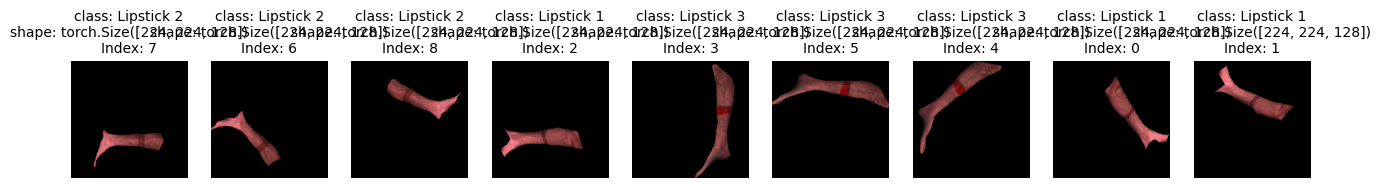

In [19]:
display_random_images(test_data_custom, #modified
                      n=9, 
                      classes=train_data_custom.classes,
                      seed=None)

# **5.4** Turn custom loaded images into `DataLoader`'s

`DataLoader` wraps in iterable around the `Dataset` to enable easy access to the samples\
source: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

An *interable* in Python is an object that can be interated over

In [20]:
# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data_custom, # use custom created train Dataset
                                     batch_size=9, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                                    # subprocesses are multiple processes, all loading data simultaneously
                                     shuffle=True) # shuffle the data?

test_dataloader_custom = DataLoader(dataset=test_data_custom, # use custom created test Dataset
                                    batch_size=9, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x144e4f820>,
 <torch.utils.data.dataloader.DataLoader at 0x144e95e20>)

In [21]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([9, 128, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([9])


left off at 
https://www.learnpytorch.io/04_pytorch_custom_datasets/#7-model-0-tinyvgg-without-data-augmentation

# **7.1:** Creating transforms and loading data for Model 0


# **7.2:** Create TinyVGG model class

And now let's follow best practice and setup device-agnostic code.

Since I am on a mac, I will have to install some additional programs which I can do later. Details at bottom of page: https://pytorch.org/blog/introducing-accelerated-pytorch-training-on-mac/

In [22]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

_____I needed to set the in_features of nn.Linear manually so that the matrix dimensions could be multiplied. Is what I did sensical?

In [23]:
import torch
from torch import nn

class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            # nn.Linear(in_features= 31360, # modified from: hidden_units*16*16,
            #           # above is same as 10*130*174
            #           out_features=output_shape)
            nn.LazyLinear(out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=128, # number of color channels (3 for RGB) - modified
                  hidden_units=10, 
                  output_shape=len(train_data_custom.classes)).to(device)
model_0

/Users/maycaj/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(128, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): LazyLinear(in_features=0, out_features=3, bias=True)
  )
)

# **7.3** Try a forward pass on a single image (to test the model)

In [24]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_custom))


# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")
print(f"Single image data type: {img_single.dtype}")
if img_single.dtype != 'torch.float32':
    img_single = img_single.to(dtype=torch.float32)  # Convert to float32
    print('Image converted datatype to float32')
print(f"Single image data type: {img_single.dtype}")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))
    
# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 128, 224, 224])

Single image data type: torch.float32
Image converted datatype to float32
Single image data type: torch.float32
Output logits:
tensor([[0.0569, 0.0019, 0.0076]])

Output prediction probabilities:
tensor([[0.3450, 0.3265, 0.3284]])

Output prediction label:
tensor([0])

Actual label:
0


# **7.4:** Use `torchinfo` to get an idea of the shapes going through our model

In [25]:
# Install torchinfo if it's not available, import it if it is
import torchinfo
from torchinfo import summary
summary(model_0, input_size=print(img_custom.shape)) # do a test pass through of an example input size 

torch.Size([9, 128, 224, 224])


Layer (type:depth-idx)                   Param #
TinyVGG                                  --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       11,530
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       910
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-6                       910
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       910
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
├─Sequential: 1-3                        --
│    └─Flatten: 2-11                     --
│    └─Linear: 2-12                      94,083
Total params: 108,343
Trainable params: 108,343
Non-trainable params: 0

**Total multi-adds** = total number of multiplications and additions – reported in Giga\
**Input size** is reported in megabytes of data

Because we're dealing with batches in the DataLoader's, we'll accumulate the model loss and accuracy values during training (by adding them up for each batch) and then adjust them at the end before we return them.

# **7.5:** Create train & test loop functions

In [26]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode - as apposed to evaluation mode - model.eval()
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad - ensure loss.backward() isn't accumulating the gradient from previous steps
        optimizer.zero_grad()

        # 4. Loss backward - determine what direction we will step in
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        # Argmax computes the indicies of the maximum value of input
        # Softmax rescales inputs so that each probability sums up to 1
        # ___ why do we need to preform softmax if we are just going to do argmax anyway?
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        # 1) determine if our predictions match the actual data
        # 2) true = 1 and false = 0, sum these
        # 3) item() converts the numbers from a tensor to a python number
        # 4) dividing by len(y_pred) computes the average
        # ___ why isn't it train_acc = , why do we accumulate accuracy each time?
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [27]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in evaluation mode (as opposed to training mode) - does stuff like turn off dropout layers
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)
            # Logits are raw prediction vectors (-inf to inf) that are usually normalized by the softmax function (0 to 1)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc, y, test_pred_labels

# **7.6** Creating a `train()` function to combine `train_step()` and `test_step()`

To keep track of the number of epochs we've been through, let's import tqdm from tqdm.auto (tqdm is one of the most popular progress bar libraries for Python and tqdm.auto automatically decides what kind of progress bar is best for your computing environment, e.g. Jupyter Notebook vs. Python script).

In [28]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
        "epoch" : [],
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc, y, test_pred_labels = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        results["epoch"].append(epoch+1)

    plt.plot(results['epoch'],results['train_loss'], label = 'train_loss')
    plt.plot(results['epoch'], results['train_acc'], label = 'train_acc')
    plt.plot(results['epoch'], results['test_loss'], label='test_loss')
    plt.plot(results['epoch'], results['test_acc'], label='test_acc')
        
    plt.legend()
    plt.show()
    # 6. Return the filled results at the end of the epochs
    return results, y, test_pred_labels


# **7.7** Train and Evaluate Model 0

/Users/maycaj/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.3125 | train_acc: 0.3472 | test_loss: 1.1110 | test_acc: 0.3333
Epoch: 2 | train_loss: 1.1609 | train_acc: 0.2847 | test_loss: 1.1515 | test_acc: 0.3333
Epoch: 3 | train_loss: 1.1297 | train_acc: 0.3472 | test_loss: 1.0280 | test_acc: 0.4444
Epoch: 4 | train_loss: 0.9484 | train_acc: 0.5764 | test_loss: 0.7938 | test_acc: 0.5556
Epoch: 5 | train_loss: 0.5571 | train_acc: 0.7153 | test_loss: 0.5451 | test_acc: 0.6667
Epoch: 6 | train_loss: 0.7608 | train_acc: 0.7674 | test_loss: 0.2652 | test_acc: 0.8889
Epoch: 7 | train_loss: 0.6444 | train_acc: 0.6597 | test_loss: 0.4867 | test_acc: 0.8889
Epoch: 8 | train_loss: 0.3391 | train_acc: 0.8576 | test_loss: 0.3144 | test_acc: 0.8889
Epoch: 9 | train_loss: 0.4236 | train_acc: 0.7674 | test_loss: 0.2406 | test_acc: 1.0000
Epoch: 10 | train_loss: 0.4115 | train_acc: 0.7708 | test_loss: 0.2646 | test_acc: 1.0000


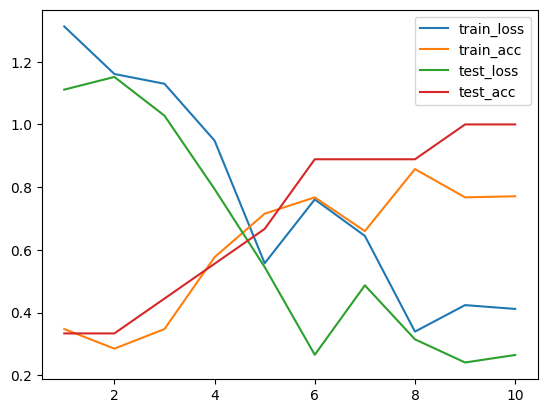

Total training time: 50.829 seconds


In [29]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 10

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=128, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data_custom.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results, y, test_pred_labels = train(model=model_0, 
                        train_dataloader=train_dataloader_custom,
                        test_dataloader=test_dataloader_custom,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

Y and test_pred_labels are the same size as the batch size

https://discuss.pytorch.org/t/how-to-find-individual-class-accuracy/6348/2

[[3 0 0]
 [0 3 0]
 [0 0 3]]
Testing accuracy: 1.0
Accuracy by category:
    Lipstick 1: 1.00
    Lipstick 2: 1.00
    Lipstick 3: 1.00


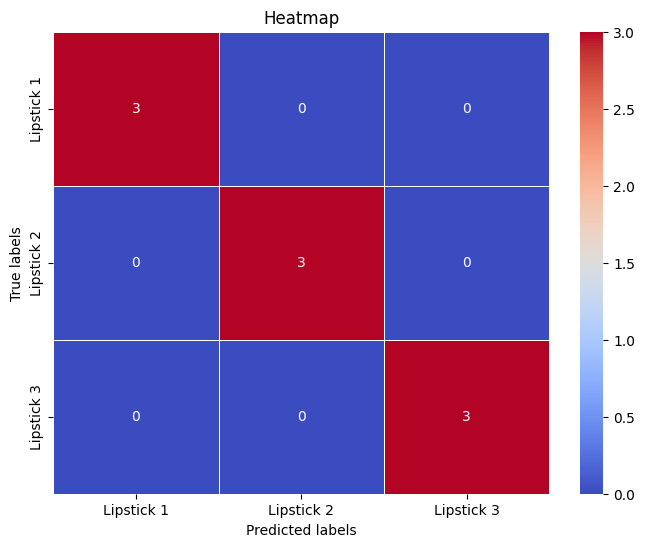

In [30]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y, test_pred_labels)

print(cm)
diagonal_sum = np.trace(cm)
accuracy = diagonal_sum/np.sum(cm)
print(f"Testing accuracy: {accuracy}")

# Calculating accuracy by category
category_accuracy = np.diag(cm) / cm.sum(axis=1)

classes = train_data_custom.classes

print("Accuracy by category:")
for i, acc in enumerate(category_accuracy):
    print(f"    {classes[i]}: {acc:.2f}")

import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='coolwarm', linewidths=.5, xticklabels=train_data_custom.classes, yticklabels=train_data_custom.classes)
plt.title('Heatmap')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

